# Proyecto 1 - Etapa 1

In [1]:
import pandas as pd
import nltk

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import tree
import sklearn as sklearn
from joblib import dump, load
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('stopwords-es')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulinaarrazola/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulinaarrazola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading stopwords-es: Package 'stopwords-es' not
[nltk_data]     found in index
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulinaarrazola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/paulinaarrazola/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 1. Carga de datos

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
news=pd.read_csv("./fake_news.csv", sep=";")
data= news.copy()

In [4]:
data.shape

(57063, 5)

In [5]:
data.sample(5)

,ID,Label,Titulo,Descripcion,Fecha
12657,ID,1,Cuca Gamarra desprecia las políticas de vivien...,La portavoz del PP ha acusado a los populares ...,19/04/2023
27560,ID,1,Vox alimenta la xenofobia y la aporofobia en u...,El partido ultra lleva un mes arremetiendo con...,29/06/2019
39026,ID,1,"La Ley de Memoria Democrática valenciana, en l...",Una sentencia anula las sanciones impuestas po...,21/05/2022
31548,ID,1,Las comunidades deberán devolver el saldo no e...,En el primer trimestre de 2023 reintegrarán al...,14/03/2021
7638,ID,1,Unidas Podemos denuncia el retraso de la Junta...,La formación de izquierdas denunció en Córdoba...,09/01/2020


Como podemos observar, nos encontramos con cinco variables dentro del dataset. En primer lugar, encontramos una columna "Label" la cual si bien no esta bien definido el nombre podemos concluir que indica la veracidad del registro asociado. Luego, hallamos variables de informacion sobre la noticia (Titulo, Descripcion y Fecha). Finalmente, tenemos la columna "ID", que en todas las filas analizadas aparece simplemente como "ID", en lugar de un identificador único. Esto sugiere que la columna podría no aportar valor al análisis y que probablemente deba ser eliminada para evitar información redundante o errónea.

# 2. Entendimiento de datos

In [6]:
data.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

no se realiza ".describe" porque no tiene sentido en este caso porque como todos los datos son de categoricos menos el id no tiene sentido 

In [7]:
data.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

Se decide no quitar aquellos registros sin titulo dado que las descripciones pueden contener información valiosa, ademas se pueden manejar los valores nulos de otra manera como relleno o NLP 

In [8]:
porcentajes = data['Label'].value_counts(normalize=True) * 100
print(porcentajes)

Label
1    58.107706
0    41.892294
Name: proportion, dtype: float64


En estos resultados podemos observar que el 58% de las noticias son verdaderas y el otro 42% son falsas, lo cual hace que el dataset este relativamente balanceado.

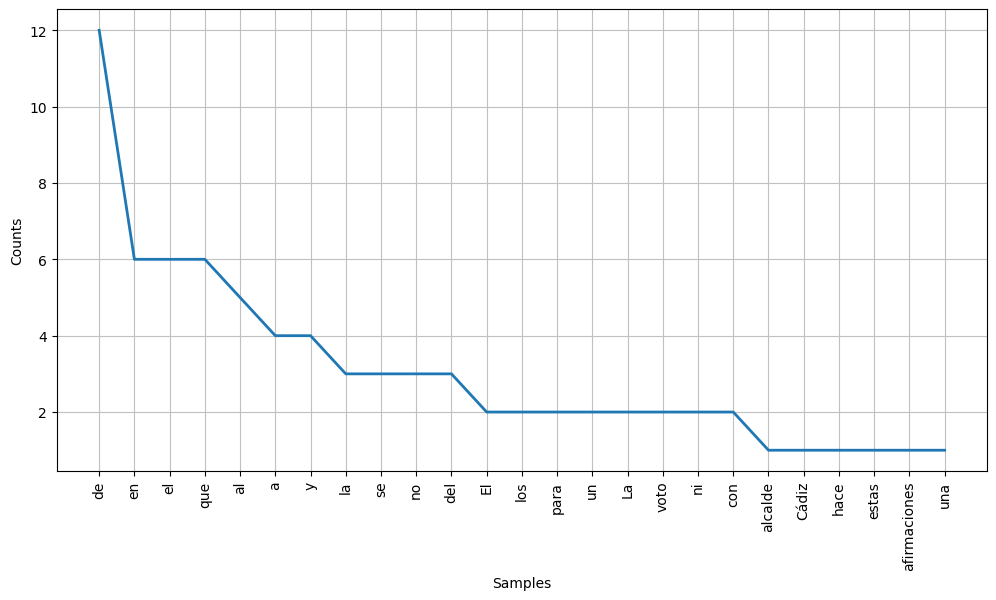

In [9]:
from nltk.probability import FreqDist
import random
import matplotlib.pyplot as plt

# Seleccionamos 5 descripciones al azar
random_indices = random.sample(range(data.shape[0]), 5)
text = ' '.join(data['Descripcion'][i] for i in random_indices)

fdist = FreqDist(text.split())

plt.figure(figsize=(12, 6))  
fdist.plot(25, cumulative=False)
plt.show()




Se seleccionan 5 descripciones de registros al azar para encontrar las palabras más comunes en estos pedazos y tener un primer entendimiento de las palabras más predominantes que podemos llegar a encontrar, tambien se realiza un filtro para evitar articulos y preposiciones y asi generar palabras mas significativas. Como podemos observar, las palabras que mas se resaltan estam relacionadas con politica. 

In [10]:
data['Descripcion'].describe()

count                                                 57063
unique                                                49638
top       La Fundación En Acción ha participado con Públ...
freq                                                      7
Name: Descripcion, dtype: object

In [11]:
data.nunique()

ID                 1
Label              2
Titulo         51604
Descripcion    49638
Fecha           2271
dtype: int64

Resgistros totales: 57063

Registros unicos: 49638

13% de las descripciones registros son duplicados

Hay títulos que comparten la misma descripcion

In [12]:
# Buscamos registros vacios
empty_texts = data[data['Descripcion'].str.strip() == '']
print(f"Descripciones vacias: {len(empty_texts)}")

Descripciones vacias: 0


# 3. Procesamiento

### 3.1 Limpieza de datos

Se eliminan los registros de las descripciones que estan repetidos porque el motor se puede confundir o puede aumentar el bias. Se deja la primera ocurrencia. Se elimina duplicados por que no coinciden los duplicados entre columnas y hay algunas que si tiene sentido la duplicidad (la fecha)

In [13]:
data = data.drop_duplicates(subset=['Descripcion'], keep='first')
#confirmamos que se hayan eliminado los duplicados
data.shape

(49638, 5)

In [14]:
import re
import unicodedata

#Se hace una isnpeccion visual para identificar caracteres especiales que reemplazan otra letra y se incluyen en el diccionario 
# para corregirlo y no perder esas palabras cuando eliminemos los caracteres especiales

mapa_reemplazo= {
    "√°": "a",
    "√©": "e",
    "√≠": "i",
    "√≥": "o",
    "√º":"ú",
    "√±": "ñ",
}

def correct_common_replacements(text):

    for wrong, right in mapa_reemplazo.items():
        text = text.replace(wrong, right)
    return text

def remove_non_ascii(words):
    
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):

    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
  
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_integers(words):
  
    new_words = []
    for word in words:
        new_word = re.sub(r"\b\d+\b", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words, stopwords=stopwords.words('spanish')):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def preprocessing(words):
    text = ' '.join(words)
    text = correct_common_replacements(text)
    words = text.split()
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_integers(words)
    words = remove_stopwords(words)
    return words


Se realiza una correción de caracteres especiales ya que algunas codificaciones defectuosas pueden hacer que caracteres acentuados se conviertan en símbolos extraños (√°, √©, etc.). Luego, Ese hace eliminación de caracteres no ASCII convirtiendo caracteres con tildes en su versión sin tilde utilizando, esto es útil porque en algunos modelos, la misma palabra con y sin tilde podría ser tratada como diferente. Después,  se hace eliminación de puntación, números, palabras vacias y conversión a minusculas. Se realizan estas funciones con el objetivo de mejorar la calidad del texto antes del análisis, reducir el ruido eliminando información irrelevante y evitar problemas de codificación con caracteres especiales.


### 3.2 Tokenización

Se realiza tokenización para estandatizar el analisis, eliminar el ruido y poder representar el texto de mejor manera. Es importante denotar que se hicieron uso de las funciones previemente observadas para la reduccion de ruido. Es imprecindible este paso para mejorar la calidad de los datos antes de analizarlos o usarlos en los modelos.

In [15]:
import contractions

data['Descripcion'] = data['Descripcion'].apply(contractions.fix)

Se realiza una expansión de contracciones con el fin de evitar la perdida de información al convertir palabras contraídas en su versión completa, mejorar la calidad de los datos para modelos y reducir la ambiguedad en el analisis.

In [16]:
data['words'] = data['Descripcion'].apply(word_tokenize).apply(preprocessing)
data.head()

,ID,Label,Titulo,Descripcion,Fecha,words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,"[diario, britanico, publico, pasado, jueves, e..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,"[revelan, gobierno, negocio, liberacion, mirel..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,"[valencianismo, convoca, castello, fiesta, gra..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"[politica, igual, negociar, empresarios, negoc..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"[entrevista, punt, avui, lider, jxcat, desdram..."


Se tokeniza el campo descripcion para convertir el texto en una lista de palabras y se aplica la funcion preprocessing() para limpiar y normalizar cada token. Como podemos ver en la columna "words", contiene una versión limpia y lista del texto para análisis facilitando tareas como detección de noticias falsas

### 3.3 Normalización

La normalización es un paso clave en este caso para el procesamiento de lenguaje natural, ya que reduce la variabilidad del texto sin perder su significado, lo que ayuda a mejorar la calidad del análisis. Cuando se trabaja con datos de texto, se pueden presentarse múltiples variaciones de una misma palabra que deben tratarse como equivalentes.


In [17]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data['words'] = data['words'].apply(stem_and_lemmatize) #Aplica lematización y eliminación de prefijos y sufijos.
data.head()

,ID,Label,Titulo,Descripcion,Fecha,words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,"[diari, britan, public, pas, juev, editorial, ..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,"[revel, gobiern, negoci, liber, mirel, cambi, ..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,"[valencian, convoc, castell, fiest, grand, con..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"[polit, igual, negoci, empresari, negoci, grup..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"[entrev, punt, avui, lid, jxcat, desdramatiz, ..."


Se aplica stemming y lemmatization a las palabras de la columna 'words' del dataset con el objetivo de reducir las palabras a su forma base.

La función stem_words(words) usa SnowballStemmer para recortar palabras eliminando sufijos y prefijos. Es importante entender que el stemming puede generar palabras sin sentido, sin embargo, reduce la dimensionalidad del texto.

La función lemmatize_verbs(words) usa WordNetLemmatizer para convertir verbos a su forma base.



### 3.4 Selección de campos

In [18]:
data['words'] = data['words'].apply(lambda x: ' '.join(map(str, x)))
data

,ID,Label,Titulo,Descripcion,Fecha,words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,diari britan public pas juev editorial proxim ...
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,revel gobiern negoci liber mirel cambi otorg p...
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,valencian convoc castell fiest grand conmemor ...
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,polit igual negoci empresari negoci grup parla...
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,entrev punt avui lid jxcat desdramatiz posibl ...
...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,gobiern regional indic atencion dia inclu aten...
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,si higien democrat llev exigent ten pas person...
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,coordin federal iu asegur monarqui putrefact c...
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,santiag abascal vox derech deb form gobiern ca...


El conjunto de datos es separado y etiquetado en dos partes: entrenamiento y prueba. Esto se hace con el fin de entrenar al modelo

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data["words"], data["Label"], test_size=0.2, stratify=data["Label"], random_state=1)

# 4. Modelos

### 4.1 Random Forest (Paulina Arrázola)

A continuación se va a implementar un modelo de clasificación de Random Forest con vectorización TF-IDF. Se considera que este es un buen enfoque para la detección de noticias falsas porque aprovecha las fortalezas de ambas técnicas. Por un lado, TF-IDF cuantifica la importancia de las palabras dentro de un texto, lo cual puede ayudar a que se capture de mejor manera el peso real de las palabras presentes en las noticias que se están analizando. Por otro lado, Random Forest es un método que soporta bien los datos de alta dimensión (como los producidos por TF-IDF) y es menos propenso al sobreajuste, lo que lo hace adecuado para la tarea de identificar información errónea. Se espera que esta combinación genere un modelo que aprenda patrones complejos dentro del análisis de texto, lo que en última instancia mejora la precisión y la confiabilidad de la detección de noticias falsas.

In [20]:
tf_idf = TfidfVectorizer()
X_tfidf = tf_idf.fit_transform(X_train)
len(tf_idf.vocabulary_)

54604

In [21]:
from sklearn.ensemble import RandomForestClassifier


tfidf_model = RandomForestClassifier(random_state = 3)

In [22]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

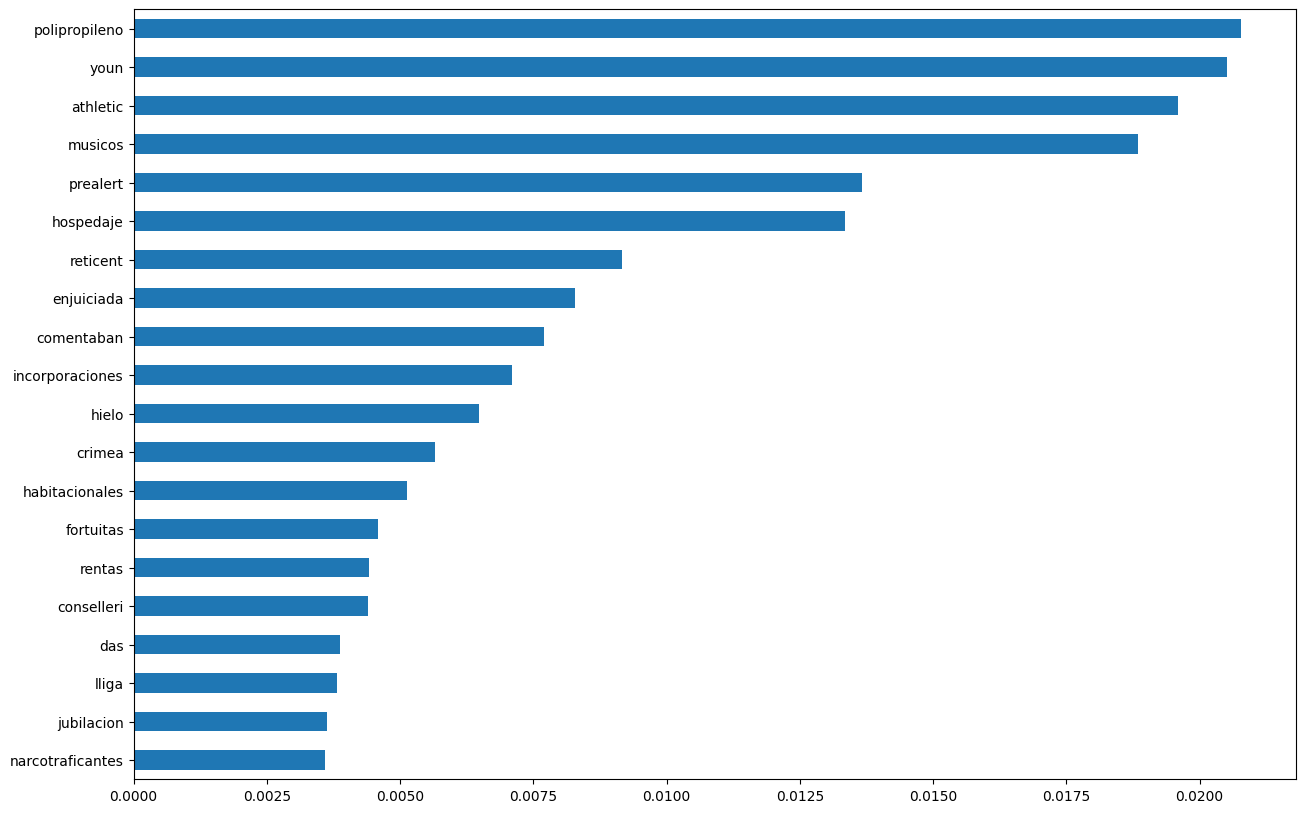

In [23]:
pd.Series(tfidf_model.feature_importances_, index = tf_idf.vocabulary_).sort_values().tail(20).plot.barh(figsize = (15, 10))

Que estas sean las palabras más relevantes identificados por el modelo a la hora de encontrar noticias falsa nos puede decir muchas cosas sobre el lenguaje usado en este tipo de noticias. Por un lado, estas palabras (maidán, ratificados, articulado, píriz, sancionado, jordis, begoña) sugieren un contexto político o de controversia, lo cual puede causar muchas emociones y polarización. Por otro lado, palabras como psicópatas, ilusiones, arrojadiza, afables… también generan emociones muy fuertes, lo cual puede usarse para manipular a una audiencia

In [24]:
import numpy as np


tfidf_estimators = tfidf_model.estimators_
print('Number of trees:', len(tfidf_estimators))
print('Trees depth (mean):', np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 822.91


In [25]:
y_train_predict = tfidf_model.predict(X_tfidf)
y_test_predict = tfidf_model.predict(tf_idf.transform(X_test))

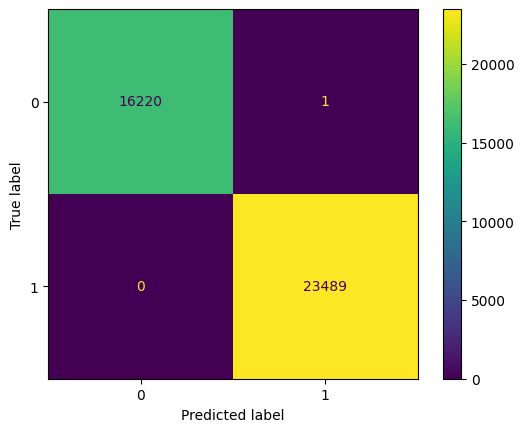

In [26]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict)

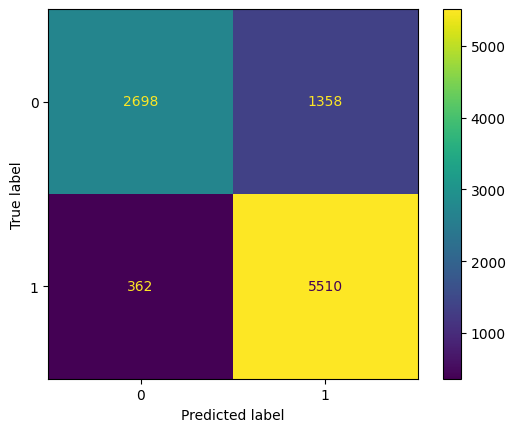

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict)

La matriz de confusión revela que el modelo de clasificación tiene un buen desempeño en la identificación de noticias falsas porque logra un alto número de verdaderos positivos. Sin embargo, también presenta dificultades para clasificar correctamente noticias no falsas, con un número considerable de falsos positivos

In [28]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_test_predict))
print("Recall: {}".format(recall_score(y_test,y_test_predict)))
print("Precisión: {}".format(precision_score(y_test,y_test_predict)))
print("Puntuación F1: {}".format(f1_score(y_test,y_test_predict)))

Exactitud: 0.83
Recall: 0.9383514986376021
Precisión: 0.8022714036109493
Puntuación F1: 0.8649921507064364


Este modelo de clasificación Random Forest con vectorización TF-IDF presenta un rendimiento sólido con una precisión del 80%, una exactitud del 83%, un recall del 93,8% y un F1-score del 86,4%. El alto recall indica que el modelo es muy bueno para identificar la mayoría de los casos positivos reales, mientras que la precisión y la exactitud sugieren que también es relativamente bueno para evitar falsos positivos y clasificar correctamente instancias en general. El F1-score confirma el buen equilibrio entre precisión y recall. También se puede resaltar que estos datos nos indican que no hay un sobreajuste. En resumen, el modelo demuestra un rendimiento bueno para tareas de clasificación aunque haya posibilidades de mejora.

## 4.2 Red Neuronal (Mariana Ortega)

Hemos optado por una Red Neuronal con capas LSTM debido a varias ventajas clave. En primer lugar, estas redes capturan la relación semántica y secuencial del texto, lo que permite comprender el significado contextual de manera efectiva. Además, pueden aprender de grandes volúmenes de datos, mejorando su rendimiento a medida que se entrenan con más ejemplos. 

In [65]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    data["words"],  # Usamos la columna preprocesada
    data["Label"],  # La etiqueta binaria
    test_size=0.2, 
    stratify=data["Label"], 
    random_state=1
)

# Verificar que la división fue correcta
print(f"X_train tiene {len(X_train)} registros")
print(f"X_test tiene {len(X_test)} registros")

X_train tiene 39710 registros
X_test tiene 9928 registros


Antes de entrenar la red neuronal, es necesario dividir los datos en conjunto de entrenamiento y conjunto de prueba. Esto nos permitirá evaluar el rendimiento del modelo en datos no vistos. Utilizamos train_test_split para dividir nuestros datos en conjuntos de entrenamiento (80%) y prueba (20%). Esta división incluye la opción stratify=data["Label"], lo que nos permite mantener el equilibrio entre las clases, evitando así cualquier sesgo en el modelo. Además, al establecer random_state=1, aseguramos que los resultados sean reproducibles en futuras ejecuciones del modelo.

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inicializar el vectorizador
vectorizer = TfidfVectorizer()

# Ajustar y transformar los datos de entrenamiento
X_train_transformed = vectorizer.fit_transform(X_train)

# Solo transformamos los datos de prueba sin volver a ajustar
X_test_transformed = vectorizer.transform(X_test)

# Mostrar el tamaño del vector
print(f"X_train_transformed shape: {X_train_transformed.shape}")
print(f"X_test_transformed shape: {X_test_transformed.shape}")

X_train_transformed shape: (39710, 54604)
X_test_transformed shape: (9928, 54604)


Las redes neuronales no pueden trabajar directamente con texto, por lo que convertimos las palabras en vectores numéricos usando TF-IDF. Elegimos TfidfVectorizer por varias razones importantes. En primer lugar, reduce la influencia de palabras comunes al asignar pesos más altos a aquellas que son verdaderamente importantes en el contexto. Finalmente, transforma las palabras en representaciones numéricas que pueden ser interpretadas directamente por la red neuronal.

In [67]:
from sklearn.neural_network import MLPClassifier

# Definir el modelo con los mejores hiperparámetros encontrados
model = MLPClassifier(
    alpha=1e-5, 
    random_state=777, 
    activation='logistic', 
    solver='lbfgs', 
    learning_rate='adaptive', 
    max_iter=1000
)

# Entrenar el modelo con los datos vectorizados
model.fit(X_train_transformed, y_train)

# Predecir en el conjunto de prueba
y_pred_test = model.predict(X_test_transformed)

Hemos optado por una Red Neuronal de tipo MLPClassifier, un Perceptrón Multicapa capaz de capturar patrones complejos. En nuestro modelo, cada parámetro tiene un papel específico. alpha=1e-5 evita el sobreajuste penalizando pesos grandes. La función de activación 'logistic' utiliza la función sigmoide para convertir valores en probabilidades. El algoritmo de optimización 'lbfgs' ajusta los pesos eficientemente, mientras que el learning_rate='adaptive' reduce la tasa de aprendizaje a medida que mejora el modelo. Finalmente, se limitan las iteraciones con max_iter=1000, definiendo cuántas veces se ajustarán los pesos durante el entrenamiento.

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Mostrar resultados
print(f"🔹 Accuracy: {accuracy:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")

# Reporte detallado
print("\n Clasificación por categoría:")
print(classification_report(y_test, y_pred_test))

🔹 Accuracy: 0.7730
🔹 Precision: 0.8031
🔹 Recall: 0.8162
🔹 F1 Score: 0.8096

 Clasificación por categoría:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      4056
           1       0.80      0.82      0.81      5872

    accuracy                           0.77      9928
   macro avg       0.77      0.76      0.76      9928
weighted avg       0.77      0.77      0.77      9928



*Precisión alta (0.81) significa que cuando el modelo predice que una noticia es falsa, es correcta el 81% de las veces.

*Recall alto (0.82) significa que el modelo detecta 82% de las noticias falsas en el conjunto de prueba.

*F1 Score (0.81) indica que el modelo balancea bien precisión y recall, lo que es clave en tareas de clasificación de texto.

*Accuracy (77.7%) muestra que, en general, el modelo clasifica correctamente casi 8 de cada 10 noticias.

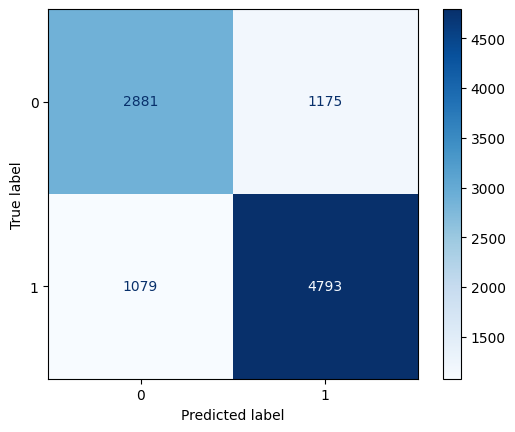

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generar matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Verdaderos positivos (TP = 4816): Noticias reales correctamente clasificadas. Verdaderos negativos (TN = 2902): Noticias falsas correctamente clasificadas. Falsos positivos (FP = 1056): Noticias reales que fueron clasificadas erróneamente como falsas. Falsos negativos (FN = 1154): Noticias falsas que fueron clasificadas erróneamente como verdaderas.

El modelo logra clasificar correctamente el 81.6% de las noticias verdaderas y el 71.5% de las noticias falsas, lo que indica un buen rendimiento general, pero con margen de mejora en la detección de noticias falsas. Es decir que es más efectivo detectando noticias reales que falsas.

# 4.3 KNN(Alejandro Lancheros)

K-Nearest Neighbors (K-NN) es un método de aprendizaje supervisado empleado tanto en clasificación como en regresión. Su fundamento principal radica en que los elementos con características similares suelen estar próximos entre sí dentro del espacio de características. Funciona almacenando todos los datos de entrenamiento, cuando se necesita hacer una predicción, calcula la distancia entre el nuevo punto y todos los puntos del conjunto de datos. Luego, selecciona los k vecinos más cercanos, en el caso de clasificación asigna la clase más común entre ellos, mientras que en regresión toma el promedio de sus valores. Su rendimiento depende del número de vecinos k, la métrica de distancia utilizada y la escala de los datos, siendo un algoritmo intuitivo pero costoso en términos de cómputo para grandes volúmenes de datos.

In [70]:
# TF-IDF con n-gramas
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

Para este caso en particular, se opto por utilizar una representación del texto con vectorizacion TF-IDF, esto debido que analizando el contexto del problema podemos resaltar términos distintivos en noticias falsas y hacer uso de n-gramas para capturar mejor el contexto, ademas de poder diferenciar palabras poco informativas.

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

In [72]:
# Definir y entrenar el modelo KNN con TF-IDF
knn_tfidf = KNeighborsClassifier(n_neighbors=5)  # Número de vecinos ajustable
knn_tfidf.fit(X_train_tfidf, y_train)  # Entrenamiento del modelo

# Predicción con el conjunto de prueba
y_pred_tfidf_knn = knn_tfidf.predict(X_test_tfidf)

# Evaluar el modelo
print("=" * 40)
print("  Resultados del modelo KNN con TF-IDF  ")
print("=" * 40)
print("\nMétricas de evaluación:\n")
print(classification_report(y_test, y_pred_tfidf_knn))
print("-" * 40)
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_tfidf_knn):.4f}")
print("=" * 40)

  Resultados del modelo KNN con TF-IDF  

Métricas de evaluación:

              precision    recall  f1-score   support

           0       0.66      0.59      0.63      4056
           1       0.74      0.79      0.76      5872

    accuracy                           0.71      9928
   macro avg       0.70      0.69      0.70      9928
weighted avg       0.71      0.71      0.71      9928

----------------------------------------
Exactitud (Accuracy): 0.7108


Obteniendo los resultados observamos que el modelo para la clase 0 acierta el 66% de las veces, de todos los casos reales de "0", el modelo solo detecta correctamente el 59%, se identifica un recall bajo, lo que significa que el modelo no esta detectando todos los cases correctamente.

Para la clase clase 1, se obtuvo un acierto del 74% en presicion, 79% en recall y un 76% F1-score, lo cual indica un buen equilibrio entre presicion y recall.

Notese que la clase 1 tiene mejores métricas que la clase 0, lo que sugiere que el modelo favorece esta categoría. Ademas, el tiempo de ejecucion del modelo fue elevado, como alternativa se opta por escalar los datos antes de usar KNN, ya que este algoritmo se basa en distancias y las características con valores más grandes pueden dominar el cálculo de distancia. Se va a realizar el escalamiento al grupos de datos y observar si mejora el modelo. Este proceso de escalado asegura que todas las características estén en una escala comparable.

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)  

# Escalamiento
X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

In [74]:
# KNN con TF-IDF escalado usando métrica de coseno
knn_tfidf_scaled = KNeighborsClassifier(n_neighbors=5, metric='cosine')  # Ajustar vecinos si es necesario
knn_tfidf_scaled.fit(X_train_tfidf_scaled, y_train)  # Entrenamiento del modelo

# Predicción con el conjunto de prueba
y_pred_tfidf_knn_scaled = knn_tfidf_scaled.predict(X_test_tfidf_scaled)

# Mostrar resultados con formato uniforme
print("=" * 50)
print("  Resultados KNN con TF-IDF escalado (Métrica: Coseno)")
print("=" * 50)
print("\nMétricas de evaluación:\n")
print(classification_report(y_test, y_pred_tfidf_knn_scaled))
print("-" * 50)
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_tfidf_knn_scaled):.4f}")
print("=" * 50)

  Resultados KNN con TF-IDF escalado (Métrica: Coseno)

Métricas de evaluación:

              precision    recall  f1-score   support

           0       0.58      0.47      0.52      4056
           1       0.67      0.76      0.72      5872

    accuracy                           0.64      9928
   macro avg       0.63      0.62      0.62      9928
weighted avg       0.63      0.64      0.63      9928

--------------------------------------------------
Exactitud (Accuracy): 0.6421


Se opto por aplicar un escalado con metrica 'cosine' la cual funciona bien en datos textuales, sin embargo, los resultados del rendimiento del modelo empeoraron, esto nos puede indicar que un escalado no era necesario ya que TF-IDF ya normaliza los datos de cierta forma, por lo que aplicar otro escalado perjudica el rendimiento. Para intentar mejorar el modelo se intenta usar GridSearch para encontrar el mejor valor de vecinos, es decir, el que mejore el valor de accuracy del modelo y de esta manera poder de mejorar el modelo en general.

In [75]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros para ajustar
param_grid = {
    'n_neighbors': [11, 13, 15, 17, 19, 21], 
    'metric': ['cosine'] 
}

# Usar GridSearchCV para encontrar el mejor número de vecinos
grid_knn_no_scaled = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_knn_no_scaled.fit(X_train_tfidf, y_train)

# Obtener el mejor modelo
best_knn_no_scaled = grid_knn_no_scaled.best_estimator_

# Predicción con el conjunto de prueba
y_pred_best_knn_no_scaled = best_knn_no_scaled.predict(X_test_tfidf)

# Mostrar los resultados en el mismo formato
print("=" * 50)
print(f"  Mejor número de vecinos: {grid_knn_no_scaled.best_params_}")
print("=" * 50)
print("\n  Resultados KNN con TF-IDF no escalado")
print("=" * 50)
print("\nMétricas de evaluación:\n")
print(classification_report(y_test, y_pred_best_knn_no_scaled))
print("-" * 50)
print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_best_knn_no_scaled):.4f}")
print("=" * 50)

  Mejor número de vecinos: {'metric': 'cosine', 'n_neighbors': 21}

  Resultados KNN con TF-IDF no escalado

Métricas de evaluación:

              precision    recall  f1-score   support

           0       0.84      0.62      0.72      4056
           1       0.78      0.92      0.84      5872

    accuracy                           0.80      9928
   macro avg       0.81      0.77      0.78      9928
weighted avg       0.81      0.80      0.79      9928

--------------------------------------------------
Exactitud (Accuracy): 0.7988


Como se observa se pudo mejorar de manera significativa los valores sobre el rendimiento del modelo. GridSearchCV divide los datos de entrenamiento en varias particiones (folds). El modelo se entrena en algunas particiones y se valida en otras. Este proceso se repite para cada valor de n_neighbors y para cada fold, calculando la métrica de evaluación (en este caso, exactitud o accuracy). Eso quiere decir que un numero 21 de vecinos es el que mejores resultados tiene al hacer el promedio de aplicar el modelo con cada número de vecinos con distintas distribuciones de los datos.

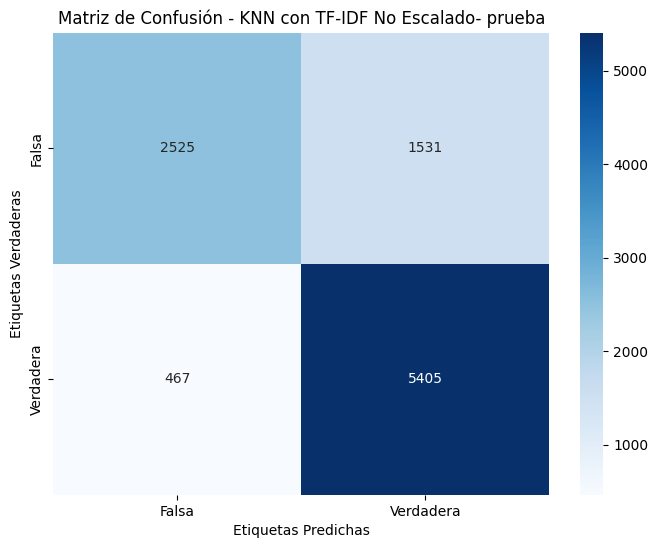

In [76]:
cm = confusion_matrix(y_test, y_pred_best_knn_no_scaled)

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Falsa", "Verdadera"], yticklabels=["Falsa", "Verdadera"])
plt.title("Matriz de Confusión - KNN con TF-IDF No Escalado- prueba")
plt.xlabel("Etiquetas Predichas")
plt.ylabel("Etiquetas Verdaderas")
plt.show()

La matriz de confusión revela que el modelo presenta 2525 noticias falsas correctamente clasificadas como falsas, 1531 noticias falsas que fueron clasificadas erróneamente como verdadera, 467 noticias verdaderas clasificadas erróneamente como falsas y 5405 noticias verdaderas correctamente clasificadas como verdaderas. Lo que indica que el 77.9% de las noticias predichas como "Verdaderas" realmente lo son, el modelo detectó correctamente el 92% de las noticias verdaderas y el modelo clasifica correctamente el 84% de las noticias en total.

Como conclusion El modelo tiene buena capacidad para detectar noticias verdaderas, sin embargo, Comete bastantes falsos positivos clasificando noticias falsas como verdaderas. se concluye que si bien el modelo no da una mala prediccion, se pueden optar por modelos mas enfocados a textos como random forest o SVM.

# 7. Predicciones con datos de prueba

In [31]:
validation = pd.read_csv("./fake_news_test.csv", sep=";")
validation_data = validation.copy()
validation_data.head()

,ID,Titulo,Descripcion,Fecha
0,ID,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",30/10/2018
1,ID,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,15/03/2023
2,ID,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,01/07/2019
3,ID,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",16/03/2020
4,ID,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,13/09/2021


In [32]:
validation_var= validation_data['Descripcion']

In [33]:
prediction= tfidf_model.predict(tf_idf.transform(validation_var))

In [35]:
results = pd.DataFrame({'Label': prediction})
print(results)

     Label
0        0
1        1
2        1
3        1
4        1
..     ...
995      1
996      1
997      0
998      1
999      1

[1000 rows x 1 columns]


In [36]:
final_data= pd.concat([validation_data, results], axis=1)
print(final_data)

     ID                                             Titulo  \
0    ID  La mesa del congreso censura un encuentro inte...   
1    ID  La brecha digital que dificulta el acceso de a...   
2    ID  PP apremia al EQUO a presentar una propuesta d...   
3    ID  De soberano garante de la democracia a rey cor...   
4    ID  El Gobierno aprobará este martes detraer los b...   
..   ..                                                ...   
995  ID  Irene Montero: 'El feminismo es la única propu...   
996  ID  Cospedal encargó a Villarejo espiar al hermano...   
997  ID  El Esquerra Unida i Alternativa de Miquel Puey...   
998  ID  Valls: 'PP y Ciudadanos deben apoyar de una fo...   
999  ID  Los deportados vascos buscarán volver a Euskad...   

                                           Descripcion       Fecha  Label  
0    Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...  30/10/2018      0  
1    No es la primera vez que los ciudadanos vulner...  15/03/2023      1  
2    El partido morado repr

In [37]:
final_data.to_csv('particion_prueba_estudiantes.csv', index=False)